In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from air_hockey_challenge.framework import AgentBase
from air_hockey_challenge.framework.air_hockey_challenge_wrapper import AirHockeyChallengeWrapper
from air_hockey_challenge.framework.challenge_core import ChallengeCore, CustomChallengeCore

/home/andang/.local/lib/python3.8/site-packages/gym/envs/registration.py:415: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(
pybullet build time: May 20 2022 19:44:17


In [2]:
from mushroom_rl.algorithms.value.dqn.dqn import DQN
from mushroom_rl.policy.deterministic_policy import DeterministicPolicy
from mushroom_rl.policy.gaussian_policy import GaussianPolicy
from mushroom_rl.approximators.parametric import TorchApproximator
from mushroom_rl.utils.optimizers import AdaptiveOptimizer
from mushroom_rl.policy import EpsGreedy

/home/andang/.local/lib/python3.8/site-packages/numpy_ml/utils/data_structures.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Hashable


# DQN

# Idea: Discretize the actions, see how plausible that is

In [4]:
env = AirHockeyChallengeWrapper('3dof-hit')
env_info = env.env_info

q = np.array([3,0,0])
dq = np.array([0,0,0])
c = env_info['constraints'].fun(q, dq)
print(c)

{'joint_pos_constr': array([ 0.18129326, -1.71      , -1.98967535, -5.81870674, -1.71      ,
       -1.98967535]), 'joint_vel_constr': array([-1.49225651, -1.49225651, -1.98967535, -1.49225651, -1.49225651,
       -1.98967535]), 'ee_constr': array([ 1.99983927, -0.67265161, -0.26904839, -0.02      , -0.02      ])}


#### Run monte carlo simulation to get the space of joint points that are good

In [5]:
def montecarlo_simulate(env_info,N):
    
    qs = []
    dqs = []
    
    for i in range(N):
        q = np.random.uniform(-3,3,size=(3,))
        dq = np.random.uniform(-3,3,size=(3,))
        
        constraints = env_info['constraints'].fun(q,dq)
        
        
        add_in = True
        for key,val in constraints.items():
                if np.any(val >= 0):
                    add_in = False
                    break
        
        if add_in:
            qs.append(q)
            dqs.append(dq)
    
    qs = np.array(qs)
    dqs = np.array(dqs)
    
    return qs,dqs

In [6]:
import matplotlib.pyplot as plt

In [7]:
qs,dqs = montecarlo_simulate(env_info,100000)

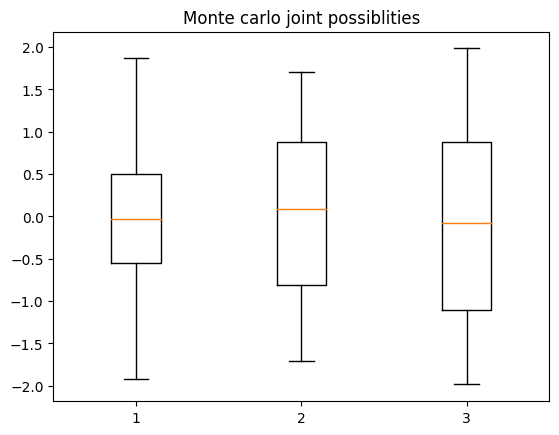

In [8]:
plt.boxplot(qs)
plt.title('Monte carlo joint possiblities')
plt.show()

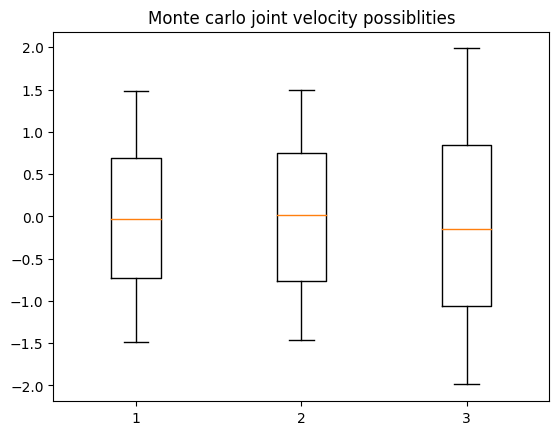

In [9]:
plt.boxplot(dqs)
plt.title('Monte carlo joint velocity possiblities')
plt.show()

In [10]:
#real joint ranges
print( env_info['robot']['robot_model'].jnt_range )

[[-2.96705973  2.96705973]
 [-1.8         1.8       ]
 [-2.0943951   2.0943951 ]]


In [11]:
#real joint vel ranges
print(env_info['robot']['joint_vel_limit'] * 0.95)

[[-1.49225651 -1.49225651 -1.98967535]
 [ 1.49225651  1.49225651  1.98967535]]


In [12]:
from air_hockey_challenge.utils.kinematics import forward_kinematics, jacobian

In [13]:
def get_xy(qs):
    
    xys = []
    for i in range(qs.shape[0]):
        q = qs[i,:]
        
        ee_pos, _ = forward_kinematics(env_info['robot']['robot_model'],env_info['robot']['robot_data'],q)
        xys.append( ee_pos )
    
    return np.array(xys)

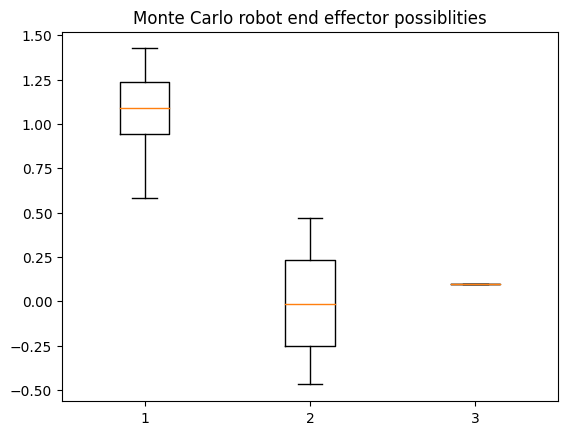

In [14]:
xys = get_xy(qs)
plt.boxplot(xys)
plt.title('Monte Carlo robot end effector possiblities')
plt.show()

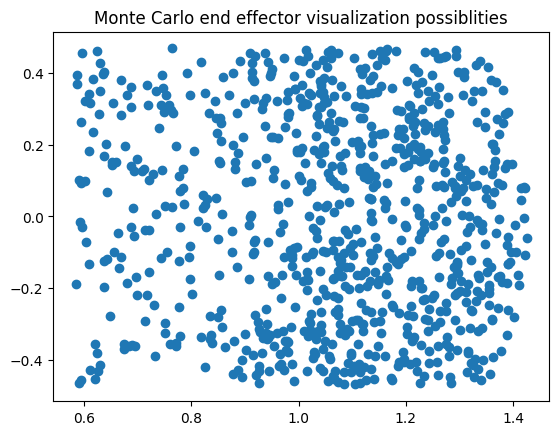

In [15]:
plt.scatter(xys[:,0],xys[:,1])
plt.title('Monte Carlo end effector visualization possiblities')
plt.show()

In [16]:
#practical table range for robot
print( env_info['table']['length']/2, env_info['table']['width']/2 )

0.974 0.519


### Conclusion: it seems super difficult to discretize all of the possible spaces to cover and write a classifier that can achieve that

### Create Value Network to Discretize Action Space

### Actions = Joint Pos & Joint Velocity

In [194]:
class ValueNetwork(nn.Module):
    def __init__(self, input_shape, output_shape, discrete_size=10,**kwargs):
        '''
            Arguments:
            ----------
                input_shape: (m,) where m is length of input
                output_shape: (m,n,..) where it represents shape of output
        '''
        super().__init__()
        
        input_dim = input_shape[0]
        output_dim = 1
        for i in output_shape: 
            output_dim *= i
        
        self.output_shape = output_shape
        activation = nn.LeakyReLU(0.1)
        
        if 'num_layers' in kwargs.keys():
            num_layers = kwargs['num_layers']
        else:
            num_layers = 20
        
        if 'layer_width' in kwargs.keys():
            layer_width = kwargs['layer_width']
        else:
            layer_width = 10
        
        
        layers = [nn.Linear(input_dim, layer_width), activation]
        for i in range(num_layers-1):
            layers.append(nn.Linear(layer_width, layer_width))
            layers.append(activation)
        layers.append(nn.Linear(layer_width, output_dim))
        layers.append(activation)
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x,action=None):
        q = self.model(x.float()) #reshape into a tensor of classes representing pos/vel
        
        if action is None:
            q = q
            return q
        else:
            action = action.long()
            q_acted = torch.squeeze(q.gather(1, action))
            
            return q_acted

### Write a custom ChallengeCore pipeline to work with discrete networks

In [195]:
import time
from mushroom_rl.core import Core

from air_hockey_challenge.framework.challenge_core import ChallengeCore
from air_hockey_challenge.framework.agent_base import AgentBase
from air_hockey_challenge.framework.air_hockey_challenge_wrapper import AirHockeyChallengeWrapper

class DiscreteChallengeCore(Core):
    def __init__(self, jnt_range, jnt_vel_range, *args, discrete_size=10, action_idx=None, **kwargs):
        
        self.discrete_size = discrete_size
        
        
        #setup discrete action space
        self.discrete_q = None
        for i in range(jnt_range.shape[0]):
            if self.discrete_q is None:
                self.discrete_q = np.linspace(jnt_range[i,0],jnt_range[i,1],discrete_size)
            else:
                self.discrete_q = np.vstack((self.discrete_q,np.linspace(jnt_range[i,0],jnt_range[i,1],discrete_size)))
        
        for i in range(jnt_vel_range.shape[0]):
            self.discrete_q = np.vstack((self.discrete_q,np.linspace(jnt_vel_range[i,0],jnt_vel_range[i,1],discrete_size)))
        
        if action_idx:
            self.action_idx = action_idx
        else:
            self.action_idx = [0, 1]
        super().__init__(*args, **kwargs)
        
    def _step(self, render):
        """
        Single step.

        Args:
            render (bool):
                whether to render or not.

        Returns:
            A tuple containing the previous state, the action sampled by the
            agent, the reward obtained, the reached state, the absorbing flag
            of the reached state and the last step flag.

        """
        start_time = time.time()
        action_q = self.agent.draw_action(self._state) #draw argmax
        
        idx = action_q[0]
        action = np.zeros((6,1),np.float32)
        
        i = 0
        while idx != 0:
            action_idx = idx % self.discrete_size
            idx = idx // self.discrete_size
            
            action[i] = self.discrete_q[i,action_idx]
            i += 1
        
        action_reshape = action.reshape(2,3)
        end_time = time.time()
        next_state, reward, absorbing, step_info = self.mdp.step(action_reshape[self.action_idx])
        step_info["computation_time"] = (end_time - start_time)

        self._episode_steps += 1

        if render:
            self.mdp.render()

        last = not (
                self._episode_steps < self.mdp.info.horizon and not absorbing)

        state = self._state
        next_state = self._preprocess(next_state.copy())
        self._state = next_state

        return (state, action, reward, next_state, absorbing, last), step_info

In [196]:
#DQN takes in different inputs

def custom_reward_function(base_env, state, action, next_state, absorbing):
    return 9000 #its over 9000

#setup environment/mdp
mdp = AirHockeyChallengeWrapper(env="3dof-hit", action_type="position-velocity", interpolation_order=3, custom_reward_function=custom_reward_function, debug=False)


#discrete action size
discrete_size = 10


#setup value network
approximator = TorchApproximator
approximator_params = dict(
                                 input_shape=mdp.info.observation_space.shape,
                                 output_shape=(10**6,),
                                 network=ValueNetwork,
                                 loss=F.mse_loss,
                                 optimizer={'class': optim.Adam, 'params': {'lr': .001}},
                                 use_cuda=False,
                                 )

#setup deterministic policy
policy = EpsGreedy(epsilon=0)


dqn = DQN(mdp_info=mdp.info,policy=policy,approximator=approximator,approximator_params=approximator_params,batch_size=32,target_update_frequency=10000)

In [197]:
core = DiscreteChallengeCore(mdp.env_info['robot']['robot_model'].jnt_range, mdp.env_info['robot']['joint_vel_limit'].T, dqn, mdp)

core.learn(n_episodes=10, n_episodes_per_fit=10, render=False) #render allows us to visualize what's going on






















  0%|                                                                                                                                                      | 0/10 [00:00<?, ?it/s]




















 10%|██████████████▏                                                                                                                               | 1/10 [00:04<00:40,  4.47s/it]




















 20%|████████████████████████████▍                                                                                                                 | 2/10 [00:09<00:37,  4.63s/it]




















 30%|██████████████████████████████████████████▌                                                                                                   | 3/10 [00:13<00:32,  4.63s/it]




















 40%|████████████████████████████████████████████████████████▊                                                                                     | 4/10 [00:18<00:27,  4.52s/it]






RuntimeError: Index tensor must have the same number of dimensions as input tensor